# Delivery Business - An overview of the NYC market

In [1]:
import pandas as pd

In this report, I'll analyze data on the operations of Jumpman23, a fictitious business that operates in the New York City market. First, I'll get the overall picture of the market and then I'll deep dive into 3 topics: Customer Experience, Jumpmen efficiency and Logistics.

In [2]:
df = pd.read_csv("analyze_me.csv")
df.head()

delivery_id  customer_id  jumpman_id vehicle_type         pickup_place  \
0      1457973       327168      162381          van            Melt Shop   
1      1377056        64452      104533      bicycle  Prince Street Pizza   
2      1476547        83095      132725      bicycle           Bareburger   
3      1485494       271149      157175      bicycle          Juice Press   
4      1327707       122609      118095      bicycle    Blue Ribbon Sushi   

  place_category                    item_name  item_quantity  \
0       American                     Lemonade            1.0   
1          Pizza        Neapolitan Rice Balls            3.0   
2         Burger                   Bare Sodas            1.0   
3      Juice Bar      OMG! My Favorite Juice!            1.0   
4       Japanese  Spicy Tuna & Tempura Flakes            2.0   

     item_category_name how_long_it_took_to_order  pickup_lat  pickup_lon  \
0             Beverages           00:19:58.582052   40.744607  -73.990742   
1            Munchables           00:25:09.107093   40.723080  -73.994615   
2                Drinks           00:06:44.541717   40.728478  -73.998392   
3   Cold Pressed Juices                       NaN   40.738868  -74.002747   
4  Maki (Special Rolls)           00:03:45.035418   40.726110  -74.002492   

   dropoff_lat  dropoff_lon   when_the_delivery_started  \
0    40.752073   -73.985370  2014-10-26 13:51:59.898924   
1    40.719722   -73.991858   2014-10-16 21:58:58.65491   
2    40.728606   -73.995143  2014-10-28 21:39:52.654394   
3    40.751257   -74.005634  2014-10-30 10:54:11.531894   
4    40.709323   -74.015867  2014-10-10 00:07:18.450505   

  when_the_Jumpman_arrived_at_pickup when_the_Jumpman_left_pickup  \
0                                NaN                          NaN   
1         2014-10-16 22:26:02.120931   2014-10-16 22:48:23.091253   
2         2014-10-28 21:37:18.793405    2014-10-28 21:59:09.98481   
3         2014-10-30 11:04:17.759577   2014-10-30 11:16:37.895816   
4         2014-10-10 00:14:42.702223   2014-10-10 00:25:19.400294   

  when_the_Jumpman_arrived_at_dropoff  
0          2014-10-26 14:52:06.313088  
1          2014-10-16 22:59:22.948873  
2          2014-10-28 22:04:40.634962  
3          2014-10-30 11:32:38.090061  
4          2014-10-10 00:48:27.150595

## Overall picture

In [3]:
from datetime import datetime as dt
from matplotlib import pyplot as plt
import folium
from folium.plugins import HeatMap

Average number of deliveries per day: 173.8


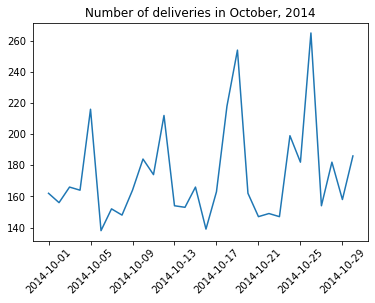

In [4]:
df["delivery_date"] = df.when_the_delivery_started.str.slice(0,10)
df.delivery_date = df.delivery_date.apply(lambda date: dt.strptime(date, '%Y-%m-%d'))

num_deliveries = df[["delivery_id", "delivery_date"]].groupby("delivery_date").nunique()
num_deliveries.columns = ["delivery_id", "temp"]

ax = plt.plot(num_deliveries.delivery_id)
ax = plt.xticks(rotation=45)
ax = plt.title("Number of deliveries in October, 2014")
print("Average number of deliveries per day: " + str(num_deliveries.delivery_id.mean()))

In [5]:
num_deliveries.delivery_id.describe()

count     30.000000
mean     173.800000
std       31.700538
min      138.000000
25%      153.250000
50%      163.500000
75%      183.500000
max      265.000000
Name: delivery_id, dtype: float64

The number of deliveries in NYC lied between **138 and 265**, with an **average of 173.8 deliveries per day**. One month of data is not enough time to spot any long term growth trend, but it would be useful to compare this number to past data of other cities that Jumpman23 entered.

Furthermore, we can see a cycle in the data. Let's explore it.

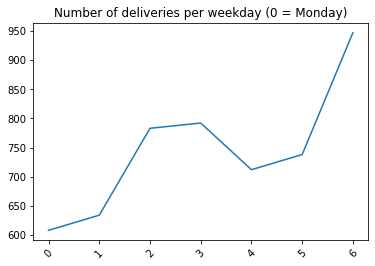

In [6]:
num_deliveries.reset_index(inplace=True)
num_deliveries["delivery_weekday"] = num_deliveries.delivery_date.apply(lambda x: x.weekday())

weekday_deliveries = num_deliveries[["delivery_id", "delivery_weekday"]].groupby("delivery_weekday").delivery_id.sum()

ax = plt.plot(weekday_deliveries)
ax = plt.xticks(rotation=45)
ax = plt.title("Number of deliveries per weekday (0 = Monday)")

The result is reasonable. We have a higher volume of deliveries on Sundays and a lower volume on Mondays.

Let's now take a look at our user base:

In [7]:
print("Number of customers: " + str(len(df.customer_id.unique())))
print("Number of jumpmen: " + str(len(df.jumpman_id.unique())))

Number of customers: 3192
Number of jumpmen: 578


For the month of October, 2014, we had **3,192 active customers** served by **578 jumpmen**. Again, it would be useful to compare those numbers with historical data. 

Finally, let's take a look at the density of deliveries by pickup location and dropoff location.

In [8]:
df["pickup_lat2"] = df.pickup_lat.apply(lambda x: round(x*100)/100)
df["pickup_lon2"] = df.pickup_lon.apply(lambda x: round(x*100)/100)
pickup_hm = df.groupby(["pickup_lat2", "pickup_lon2"]).delivery_id.nunique().reset_index()

hmap = folium.Map(titles="A", location=[df.pickup_lat.mean(), df.pickup_lon.mean()], zoom_start=12)

hm_wide = HeatMap( list(zip(pickup_hm.pickup_lat2.values, pickup_hm.pickup_lon2.values, pickup_hm.delivery_id.astype(float).values)),
                   min_opacity=0.2,
                   max_val=pickup_hm.delivery_id.max(),
                   radius=25, blur=15, 
                   max_zoom=1, 
                 )

loc = 'Density of delivery pickups'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
hmap.get_root().html.add_child(folium.Element(title_html))
hmap.add_child(hm_wide)

In [9]:
df["dropoff_lat2"] = df.dropoff_lat.apply(lambda x: round(x*100)/100)
df["dropoff_lon2"] = df.dropoff_lon.apply(lambda x: round(x*100)/100)
dropoff_hm = df.groupby(["dropoff_lat2", "dropoff_lon2"]).delivery_id.nunique().reset_index()

hmap = folium.Map(location=[df.dropoff_lat.mean(), df.dropoff_lon.mean()], zoom_start=12)

hm_wide = HeatMap( list(zip(dropoff_hm.dropoff_lat2.values, dropoff_hm.dropoff_lon2.values, dropoff_hm.delivery_id.astype(float).values)),
                   min_opacity=0.2,
                   max_val=dropoff_hm.delivery_id.max(),
                   radius=25, blur=15, 
                   max_zoom=1, 
                 )
loc = 'Density of delivery dropoffs'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
hmap.get_root().html.add_child(folium.Element(title_html))
hmap.add_child(hm_wide)

We can see that both pickups and dropoffs are **concentrated in Lower and Midtown Manhattan**. One hypothesis is that, as most of Jumpan23 partnerships with pickup places are in Lower and Midtown Manhattan, the delivery time to other regions is high, which makes the customer experience not good. Then, it would make sense to expand the partnerships to other regions of Manhattan and even the suburbs of NYC. In the next topic section, I'll explore the delivery time.

## Customer Experience

Here, I'm going to analyze customer behavior and experience in the platform. First, let's see how many orders per customer we had over time.

Average orders per customer per week: 1.1769751693002257
Average orders per customer overall: 1.6334586466165413


count    3192.000000
mean        1.633459
std         1.402995
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        23.000000
Name: delivery_id, dtype: float64

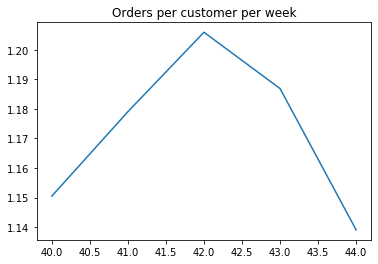

In [10]:
df["delivery_week"] = df.delivery_date.apply(lambda date: date.isocalendar()[1])

orders_per_cust = df[["delivery_id", "customer_id", "delivery_week"]].groupby("delivery_week").nunique()
orders_per_cust
orders_per_cust.columns = ["delivery_id", "customer_id", "temp"]

ax = plt.plot(orders_per_cust.delivery_id/orders_per_cust.customer_id)
ax = plt.title("Orders per customer per week")
print("Average orders per customer per week: " + str(orders_per_cust.delivery_id.sum()/orders_per_cust.customer_id.sum()))
print("Average orders per customer overall: " + str(df.delivery_id.nunique()/df.customer_id.nunique()))
df.groupby("customer_id").delivery_id.nunique().describe()

We had on average **1.63 orders per customer in NYC in October 2014**, and on average **1.18 orders per week**. Also, 75% of customers ordered twice or less, and the maximum number of orders for a customer was 23. We should try to increase the frequency of orders with promotions and targeted advertisement and we should retain yhe high frequency customers.

We can see a peak in week 42, but the standard deviation is pretty low. It would be interesting to compare those numbers with past data.

Let's now see how many items we have per order on average. Here, we have missing data for the item name, but we know that each row corresponds to a different item.

In [11]:
items_per_order = df.groupby("delivery_id").count().customer_id
print("# items per order: " + str(items_per_order.mean()))
items_per_order.describe()

# items per order: 1.1474875335634829


count    5214.000000
mean        1.147488
std         0.420915
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: customer_id, dtype: float64

Most of the time, customers tend to order only 1 item in the platform, with a maximum value of 5 items. Therefore, the company should think of ways to make customers add more items in the checkout, as for example recommending other items that go well together.

In [12]:
df.groupby("place_category").delivery_id.nunique().sort_values(ascending=False)

place_category
Italian                  437
Burger                   395
American                 357
Japanese                 335
Dessert                  277
Chinese                  265
Sushi                    203
Salad                    192
Mexican                  165
Grocery Store            130
Bakery                   126
BBQ                      114
Pizza                     94
Juice Bar                 91
Indian                    80
Fast Food                 80
Donut                     71
Seafood                   69
Drug Store                68
Mediterranean             61
Vegetarian                60
Coffee                    60
Deli                      56
Middle Eastern            56
Ice Cream                 54
Gluten-Free               53
Breakfast                 45
Shop                      41
South American            33
Steak                     31
Thai                      31
French                    24
Southern                  23
Promo                     19

The **top place category** ordered in NYC is **Italian**, followed by **Burger** and **American**. The **least ordered category** is **Clothing**, tied up with other categories like Book Store. Therefore, the company should understand if people are not interested by clothing and books, or if the platform doesn't provide a good experience in those categories (few places or few items available). 

In [13]:
df.groupby("pickup_place").delivery_id.nunique().sort_values(ascending=False)

pickup_place
Shake Shack                  266
Momofuku Milk Bar            162
The Meatball Shop            153
sweetgreen                   138
Blue Ribbon Fried Chicken    115
                            ... 
Rai Rai Ken                    1
Grimaldi's Pizza               1
Grimaldi's Pizzeria            1
Rag & Bone Showroom            1
Doughnuttery                   1
Name: delivery_id, Length: 898, dtype: int64

  The **top place ordered** in NYC is **Shake Shack**, so Jumpman should maintain a good relationship with this stakeholder.

Let's now see how long it takes for a customer to place an order.

In [14]:
df.how_long_it_took_to_order = df.how_long_it_took_to_order.apply(lambda date: dt.strptime(date, '%H:%M:%S.%f') if date==date else date)

In [15]:
df["seconds_to_order"] = df.how_long_it_took_to_order.apply(lambda time: time.minute*60 + time.second if time != None else time)

time_to_order = df.groupby("delivery_id").seconds_to_order.agg(["mean", "count"]).dropna()
time_to_order["avg_time"] = time_to_order["mean"]/time_to_order["count"]
print("Avg time to place an order (minutes): " + str(time_to_order["mean"].mean()/60))
print("Avg time per item to place an order (minutes): " + str(time_to_order.avg_time.mean()/60))

Avg time to place an order (minutes): 7.620712162336823
Avg time per item to place an order (minutes): 6.953561350221879


It takes around **7.6 minutes** for customers to order in the platform, and around **7 minutes per item**. It would be useful to compare those values with past data from other cities, as well.

## Jumpmen efficiency

In [16]:
from datetime import timedelta as td
import seaborn as sns

Let's now analyse the operations from the perspective of the Jumpmen. First, it is interesting to know the number of deliveries each Jumpmen performs on average.

count    578.000000
mean       9.020761
std       10.324354
min        1.000000
25%        2.000000
50%        5.000000
75%       12.000000
max       67.000000
Name: delivery_id, dtype: float64

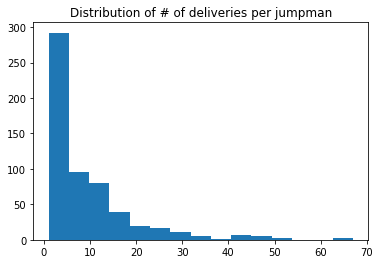

In [17]:
dlvrs_per_jumpman = df.groupby("jumpman_id").delivery_id.nunique()
plt.hist(dlvrs_per_jumpman, bins=15)
plt.title("Distribution of # of deliveries per jumpman")
dlvrs_per_jumpman.describe()

In [18]:
dlvrs_per_jumpman.sort_values(ascending=False).head(5)

jumpman_id
99219     67
142394    67
104533    67
30743     52
3296      50
Name: delivery_id, dtype: int64

**Most of Jumpmen delivered only once**, which is a low number. Jumpman23 should think of ways to increase loyalty of jumpmen, as for example creating targets of number of deliveries and rewarding jumpmen for that.

On average, they deliver around **9 times** and the maximum number of deliveries was **67**. The top performers, as '99219', should get incentives to stay in the platform.

Let's see the number of active Jumpmen over time.

Text(0.5, 1.0, '% utilization of Jumpmen')

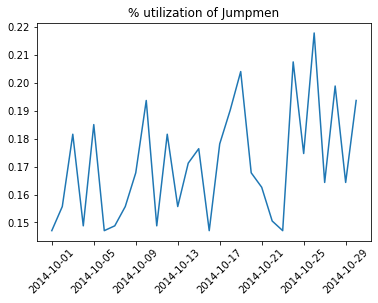

In [19]:
plt.plot(df.groupby("delivery_date").jumpman_id.nunique()/df.jumpman_id.nunique())
ax = plt.xticks(rotation=45)
plt.title("% utilization of Jumpmen")

From the active Jumpmen in October 2014, we had a **% of utilization** ranging between **14% and 22%** per day. However, we can't reach any conclusions with this data, because we don't know if the remaining Jumpmen were connected to the platform waiting for deliveries or if they were offline.

Let's now see how long it takes to commute around the city. As for some deliveries the delivery started after the Jumpman arrived at the pickup, I'll consider that it took 0 minutes to commute in these cases.

In [20]:
df["pickup_commute_time"] = df.when_the_Jumpman_arrived_at_pickup.apply(lambda time: dt.strptime(time, '%Y-%m-%d %H:%M:%S.%f') if time==time else time)-df.when_the_delivery_started.apply(lambda time: dt.strptime(time, '%Y-%m-%d %H:%M:%S.%f') if time==time else time)
df.pickup_commute_time = df.pickup_commute_time.apply(lambda x: 0 if x.days < 0 else x.seconds/60)

df["dropoff_commute_time"] = df.when_the_Jumpman_arrived_at_dropoff.apply(lambda time: dt.strptime(time, '%Y-%m-%d %H:%M:%S.%f') if time==time else time)-df.when_the_Jumpman_left_pickup.apply(lambda time: dt.strptime(time, '%Y-%m-%d %H:%M:%S.%f') if time==time else time)
df.dropoff_commute_time = df.dropoff_commute_time.apply(lambda x: 0 if x.days < 0 else x.seconds/60)

df["total_commute_time"] = df.pickup_commute_time + df.dropoff_commute_time
total_commute_time = df.groupby(["jumpman_id", "delivery_id"]).total_commute_time.mean().reset_index()

C:\Users\fellipefcm\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\fellipefcm\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


count    565.000000
mean      26.953660
std       10.442533
min        2.316667
25%       19.866667
50%       26.152381
75%       32.142857
max       84.333333
Name: total_commute_time, dtype: float64

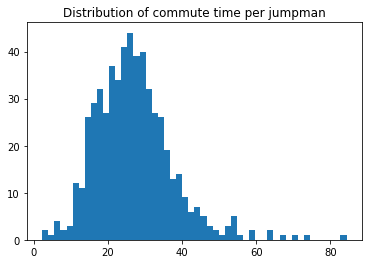

In [21]:
total_commute_per_jumpman = total_commute_time.groupby("jumpman_id").total_commute_time.mean()

ax = plt.hist(total_commute_per_jumpman, bins=50)
plt.title("Distribution of commute time per jumpman")

total_commute_per_jumpman.describe()

On average, a Jumpman takes around **27 minutes** commuting in NYC picking up and dropping off. The fastest Jumpman took on average **2.3 minutes** and the slowest, **84.3 minutes** on average. The fast ones are probably lucky to get pickup and dropoff locations close to each other. However, it would be interesting to understand why some jumpmen are taking almost 1 hour and a half to commute. It may be due to traffic, pickup and dropoff not close to each other, slow mean of transportation or other inefficiency.

Let's now break down the commute time into pickup and dropoff commute time.

count    565.000000
mean      11.871461
std        6.985575
min        0.000000
25%        6.700000
50%       11.400000
75%       16.328431
max       38.472222
Name: pickup_commute_time, dtype: float64

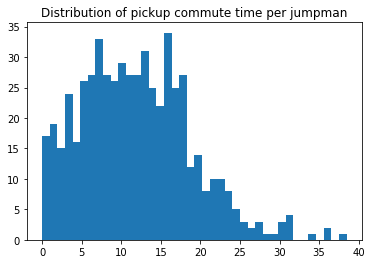

In [22]:
pickup_commute_time = df.groupby(["jumpman_id", "delivery_id", "pickup_lat2", "pickup_lon2"]).pickup_commute_time.mean().reset_index()

pickup_commute_per_jumpman = pickup_commute_time.groupby("jumpman_id").pickup_commute_time.mean()

ax = plt.hist(pickup_commute_per_jumpman, bins=40)
plt.title("Distribution of pickup commute time per jumpman")

pickup_commute_per_jumpman.describe()

The distribution of pickup commute time is a little different. We have a considerable amount of Jumpmen that arrived at the pickup before the delivery started. On average, it took around **12 minutes** for Jumpmen to pick up an order, with a maximum average time of **38.5 minutes** for some Jumpman, probably because they were assigned more distant pickups or because they usually work during peak traffic hours.

count    565.000000
mean      15.082199
std        7.332435
min        0.833333
25%       10.689000
50%       13.626667
75%       17.208333
max       69.616667
Name: dropoff_commute_time, dtype: float64

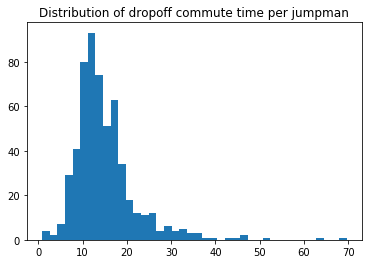

In [23]:
dropoff_commute_time = df.groupby(["jumpman_id", "delivery_id", "dropoff_lat2", "dropoff_lon2"]).dropoff_commute_time.mean().reset_index()

dropoff_commute_per_jumpman = dropoff_commute_time.groupby("jumpman_id").dropoff_commute_time.mean()

ax = plt.hist(dropoff_commute_per_jumpman, bins=40)
plt.title("Distribution of dropoff commute time per jumpman")

dropoff_commute_per_jumpman.describe()

The dropoff distribution looks more gaussian. On average, Jumpmen took **15 minutes** to drop orders off, with a maximum average time of **69.6** for some Jumpman, probably because they were assigned distant dropoffs or because they usually work during peak traffic hours.

We can see that dropoff is slightly slower than pickup. It would be useful for Jumpman23 to do a deep dive on those anomalous drivers to understand if they are slow because of external factors like traffic, distance and mean of transportation, or because they are not efficient.

It is usufel to analyze the commute time versus the pickup and dropoff location, to see if places distant from Lower and Midtown Manhattan have a higher commute time because Jumpmen and places are concentrated in that region.

In [24]:
pickup_hm = df.groupby(["pickup_lat2", "pickup_lon2", "delivery_id"]).mean().groupby(["pickup_lat2", "pickup_lon2"]).pickup_commute_time.mean().reset_index()

hmap = folium.Map(titles="A", location=[df.pickup_lat.mean(), df.pickup_lon.mean()], zoom_start=12)

hm_wide = HeatMap( list(zip(pickup_hm.pickup_lat2.values, pickup_hm.pickup_lon2.values, pickup_hm.pickup_commute_time.values)),
                   min_opacity=0.2,
                   max_val=pickup_hm.pickup_commute_time.max(),
                   radius=25, blur=15, 
                   max_zoom=1, 
                 )

loc = 'Density of delivery pickup time'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
hmap.get_root().html.add_child(folium.Element(title_html))
hmap.add_child(hm_wide)

In [25]:
dropoff_hm = df.groupby(["dropoff_lat2", "dropoff_lon2", "delivery_id"]).mean().groupby(["dropoff_lat2", "dropoff_lon2"]).dropoff_commute_time.mean().reset_index()

hmap = folium.Map(titles="A", location=[df.dropoff_lat.mean(), df.dropoff_lon.mean()], zoom_start=12)

hm_wide = HeatMap( list(zip(dropoff_hm.dropoff_lat2.values, dropoff_hm.dropoff_lon2.values, dropoff_hm.dropoff_commute_time.values)),
                   min_opacity=0.2,
                   max_val=dropoff_hm.dropoff_commute_time.max(),
                   radius=25, blur=15, 
                   max_zoom=1, 
                 )

loc = 'Density of delivery dropoff time'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
hmap.get_root().html.add_child(folium.Element(title_html))
hmap.add_child(hm_wide)

We can see that places far from the Lower and Midtown Manhattan have considerably higher commute times, especially dropoff commute time. This validates our initial hypothesis that people in the suburbs are having a worse experience. Jumpman23 should consider expanding the partnerships with businesses in those distant neighbourhoods.

Let's now analyze the time Jumpmen spend waiting to pick up.

count    540.000000
mean      19.303562
std        7.511331
min        5.816667
25%       14.665972
50%       17.848395
75%       21.967666
max      101.866667
Name: wait_time, dtype: float64

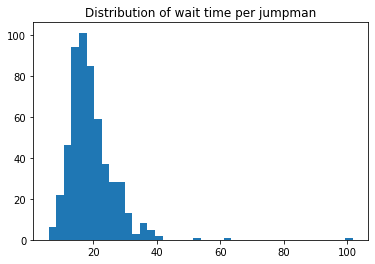

In [26]:
df["wait_time"] = df.when_the_Jumpman_left_pickup.apply(lambda time: dt.strptime(time, '%Y-%m-%d %H:%M:%S.%f') if time==time else time)-df.when_the_Jumpman_arrived_at_pickup.apply(lambda time: dt.strptime(time, '%Y-%m-%d %H:%M:%S.%f') if time==time else time)
df.wait_time = df.wait_time.apply(lambda x: 0 if x.days < 0 else x.seconds/60)

wait_time = df.groupby(["jumpman_id", "delivery_id", "place_category", "pickup_place"]).wait_time.mean().reset_index()

wait_time_per_jumpman = wait_time.groupby("jumpman_id").wait_time.mean()

ax = plt.hist(wait_time_per_jumpman, bins=40)
plt.title("Distribution of wait time per jumpman")

wait_time_per_jumpman.describe()

We have again a near normal distribution, with some anomalous cases. On average, a Jumpman waits for around **20 minutes** in the pickup location, and it varies **from 6 to 100 minutes**. It is very important to understand what happened with the Jumpman who waited 100 minutes, because it affects a lot the customer experience. It could be a problem in the pickup place, in the data collection or a problem with the driver.

Let's now segment the wating time by place category.

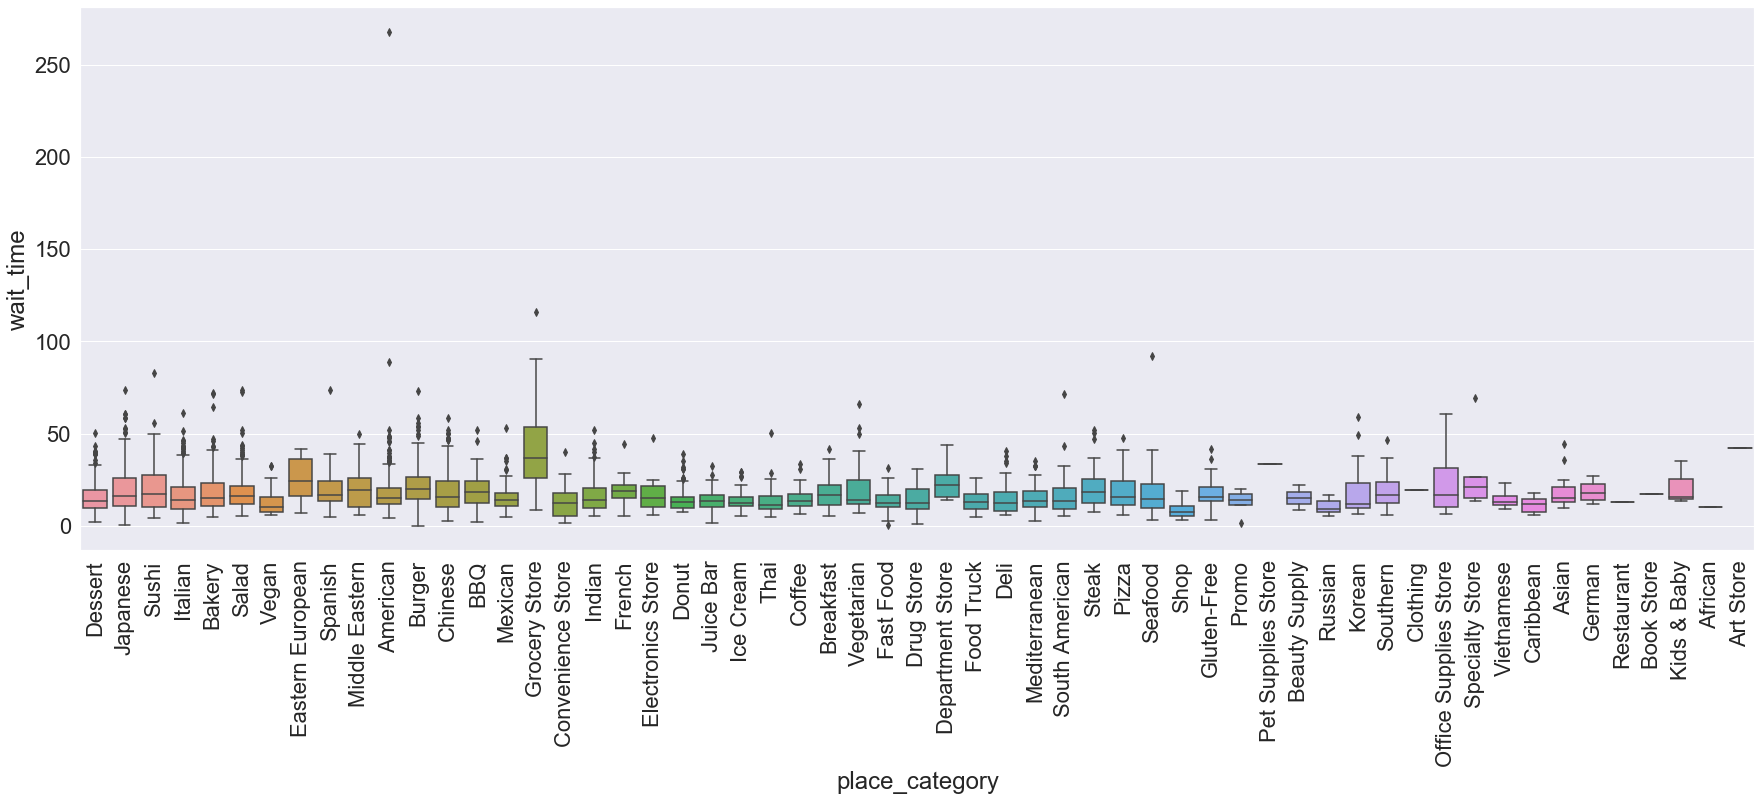

In [27]:
ax = plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.boxplot(x=wait_time.place_category, y=wait_time.wait_time)
ax = plt.xticks(rotation=90)

In [28]:
wait_time.groupby("place_category").wait_time.mean().sort_values(ascending=False)[[0,1,-2,-1]]

place_category
Art Store        42.350000
Grocery Store    40.759821
Russian          10.145833
Shop              8.585897
Name: wait_time, dtype: float64

The **fastest** waiting time were on the categories **Russian** and **Shop**, while the **slowest** were on the cateogories **Art Store** (few data points, though) and **Grocery Store**. It makes sense, as usually doing groceries is very time consumming. It would be interesting to find ways of speeding up the grocery shopping, but this would require cooperation from both Jumpmen and the grocery stores.

In [29]:
wait_time.groupby("pickup_place").wait_time.mean().sort_values(ascending=False).head()

pickup_place
Denny's                  51.733333
Friend of a Farmer       51.000000
Lantern Thai Kitchen     50.300000
Trader Joe's             47.668803
Gemma at Bowery Hotel    46.333333
Name: wait_time, dtype: float64

The **slowest place was Denny's**, a dinner restaurant chain, followed by **Friend of a Farmer**. Jumpman23 should investigate why waiting time is so high in those places.

## Logistics

In [30]:
import math
import numpy as np

Here, I'm going to check how the logistics operation is doing. I'll first start by segmenting the means of transportation.

Text(0.5, 1.0, '# of deliveries per vehicle type')

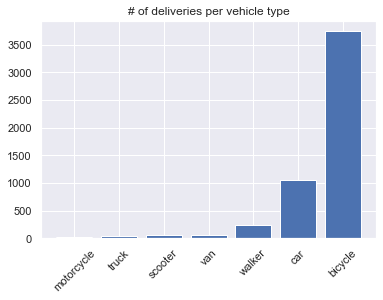

In [31]:
y = df.groupby("vehicle_type").delivery_id.nunique().sort_values()
sns.set(font_scale = 1)
ax = plt.xticks(rotation=45)
plt.bar(y.index,y)
plt.title("# of deliveries per vehicle type")

Most of the deliveries are currently done by bycicle.

Let's see how the vehicle type affects the commute speed.

In [32]:
R = 6371e3
phi1 = df.pickup_lat * math.pi/180
phi2 = df.dropoff_lat * math.pi/180;
delta_phi = (df.dropoff_lat-df.pickup_lat) * math.pi/180;
delta_lambda = (df.dropoff_lon-df.pickup_lon) * math.pi/180;

a = np.sin(delta_phi/2) * np.sin(delta_phi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

K = 0.000621371
df["pickup_dropoff_distance"] = R * c * K # in miles

(0, 40)

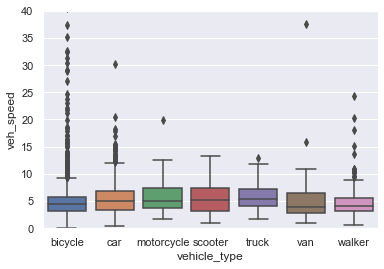

In [33]:
commute_per_veh = df.groupby(["vehicle_type", "delivery_id"])[["pickup_dropoff_distance", "dropoff_commute_time"]].mean().reset_index()
commute_per_veh["veh_speed"] = commute_per_veh.pickup_dropoff_distance*60/commute_per_veh.dropoff_commute_time
sns.boxplot(x=commute_per_veh.vehicle_type, y=commute_per_veh.veh_speed)
plt.ylim(0,40)

In [34]:
speed_per_veh = commute_per_veh.groupby("vehicle_type").sum()
speed_per_veh.veh_speed = speed_per_veh.pickup_dropoff_distance*60/speed_per_veh.dropoff_commute_time
speed_per_veh.veh_speed.sort_values()

vehicle_type
bicycle       5.016317
walker        5.069557
van           5.258920
car           6.076134
scooter       6.080280
motorcycle    6.557026
truck         6.954760
Name: veh_speed, dtype: float64

Here, I used the linear distance between 2 coordinates to calculate the speed. For distant points that is a fair approximation, but for closeby points it can underestimate a lot the real distance.
Having said that, the **truck** is the **fastest** mean of transportation, with an average speed of **7 miles per hour**, while the **bicycle and walker** are the **slowest**, with an average speed of **5 miles per hour**.

Ideally, we should use walker, bicycle and scooter for lower quantities and cars, vans and trucks for larger quantities delivered. I'll check if this is happening now.

In [35]:
df.groupby(["vehicle_type", "delivery_id"]).item_quantity.sum().groupby("vehicle_type").mean().sort_values()

vehicle_type
van           1.028986
scooter       1.046875
motorcycle    1.052632
walker        1.106838
bicycle       1.131283
car           1.175238
truck         1.342105
Name: item_quantity, dtype: float64

Indeed, trucks deliver a larger quantity than the other vehicles, but the van delivers the smallest quantity. Let's check the types of items delivered by vans.

In [36]:
df.query("vehicle_type == 'van'").head(20)

delivery_id  customer_id  jumpman_id vehicle_type  \
0         1457973       327168      162381          van   
223       1486133        41409      171206          van   
505       1431040       328072      165830          van   
515       1338928        42188      104146          van   
588       1402218       328849      165830          van   
599       1336969       372695      104146          van   
652       1407290       166010      162381          van   
1024      1276907       325403      146428          van   
1055      1455748       373311      171206          van   
1096      1474580       355445      165830          van   
1111      1467153        41378      171206          van   
1143      1294745        91274      104146          van   
1189      1476070       130507      171206          van   
1355      1397463        69816      165830          van   
1395      1439576        93505      171206          van   
1493      1407199       297130      162381          van   
1504      1411636        57943      162381          van   
1591      1293696        87151      104146          van   
1646      1412044        50633      162381          van   
1704      1398882        98219      165830          van   

                 pickup_place place_category                       item_name  \
0                   Melt Shop       American                        Lemonade   
223               Juice Press      Juice Bar                 Heaven on Earth   
505                    Momoya          Sushi                      California   
515                      Parm        Italian                   Ricotta Toast   
588       Momofuku Noodle Bar            NaN                  Momofuku Ramen   
599          Russ & Daughters        Seafood                   Pastrami Russ   
652             The Body Shop            NaN                             NaN   
1024              Duane Reade     Drug Store                             NaN   
1055              Ess-a-Bagel         Bakery                      Plain Tofu   
1096              Burger King            NaN                             NaN   
1111                Starbucks         Coffee                             NaN   
1143                     Ngam           Thai                             NaN   
1189               Hu Kitchen    Gluten-Free  1/2 Organic Rotisserie Chicken   
1355                 Boqueria        Spanish     Ensalada de Hinojo y Gambas   
1395      Momofuku Noodle Bar            NaN                Spicy Miso Ramen   
1493   Doughnut Plant Chelsea          Donut                        iced Tea   
1504                Pinkberry      Ice Cream                             NaN   
1591               sweetgreen          Salad  Organic Lentil + Chickpea Soup   
1646  Serafina Fabulous Pizza        Italian           Carciofi E Parmigiano   
1704             Kum Gang San            NaN                             NaN   

      item_quantity                                 item_category_name  \
0               1.0                                          Beverages   
223             1.0                            Raw Superfood Smoothies   
505             2.0                                               Roll   
515             1.0                                              Bread   
588             1.0                                              Bowls   
599             1.0                                         Sandwiches   
652             NaN                                                NaN   
1024            NaN                                                NaN   
1055            1.0                     Sandwiches - Cream Cheese/Tofu   
1096            NaN                                                NaN   
1111            NaN                                                NaN   
1143            NaN                                                NaN   
1189            1.0  Lunch + Dinner (M-F 11:30a-Close, Sa-Su 12p-Cl...   
1355            1.0                              

It seems that regular meals are being delivered by trucks in small quantities, which is not optimal. Maybe Jumpman23 should try to implement a shared delivery system, where trucks, vans and cars pick items up in more than 1 place and deliver to multiple customers. In order for that to work, we need to verify if we have multiple orders in nearby pickup and dropoff places.

In [37]:
df.when_the_delivery_started = df.when_the_delivery_started.apply(lambda date: dt.strptime(date, '%Y-%m-%d %H:%M:%S.%f') if date==date else date)

In [38]:
start = dt.fromisoformat('2014-10-05 12:49:30')
end = start + td(minutes=2)

df_map = df.query("when_the_delivery_started >= @start and when_the_delivery_started <= @end")

pickups = df_map[['pickup_lat', 'pickup_lon']]
pickup_list = pickups.values.tolist()
dropoffs = df_map[['dropoff_lat', 'dropoff_lon']]
dropoff_list = dropoffs.values.tolist()

hmap = folium.Map(titles="A", location=[df.pickup_lat.mean(), df.pickup_lon.mean()], zoom_start=12)

for i in range(len(pickups)):
    folium.Marker(pickup_list[i], icon=folium.Icon(color='green')).add_to(hmap)
    folium.Marker(dropoff_list[i], icon=folium.Icon(color='red')).add_to(hmap)

loc = 'Pickup and dropoff locations in a time window of 2 minutes'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
hmap.get_root().html.add_child(folium.Element(title_html))
hmap

In the example above, we can see that 2 of the 3 pickup points in green are very close to each other in a time interval of 2 minutes (in an interval of 2 minutes, we started those 3 deliveries in the map). This means that there was an opportunity for a Jumpman to do multiple pickups and then drop the orders off in each dropoff location. Jumpan23 coould then implement an online routing system to assign multiple nearby pickup and dropoff points to drivers. The customer could wait 2 minutes for the routing algorithm to find other orders, for example.